## Distortion correction with Au SAED data 
Adapted from Tina Bergh


In [2]:
# Import packages:
import numpy as np
import hyperspy.api as hs # v1.7.1
import matplotlib.pyplot as plt 
# Activate interactive plotting:
%matplotlib inline
import skimage as ski
import pyxem as pxm  # v0.14.2 dependent on Pint v0.19.1

from pyxem.generators.calibration_generator import CalibrationGenerator
from scipy.signal import argrelextrema

from hyperspy.misc.utils import stack as stack_method
from numpy import log10

from scipy.spatial import distance_matrix

Load .mib input file:

In [3]:
file = 'AuX_80kV_200cm'
folder = 'D:/Aurora/Master data/DataFebruar/240215_AuX_80kV/' 


file_ending = '.mib'
saed = pxm.load_mib(folder + file + file_ending)
saed.compute()
saed = pxm.signals.ElectronDiffraction2D(saed).inav[0]
saed.save(folder+file+'_s.hdf5')

This mib file appears to be TEM data. The stack is returned with no reshaping.
[########################################] | 100% Completed | 131.00 ms


Set center of direct beam:

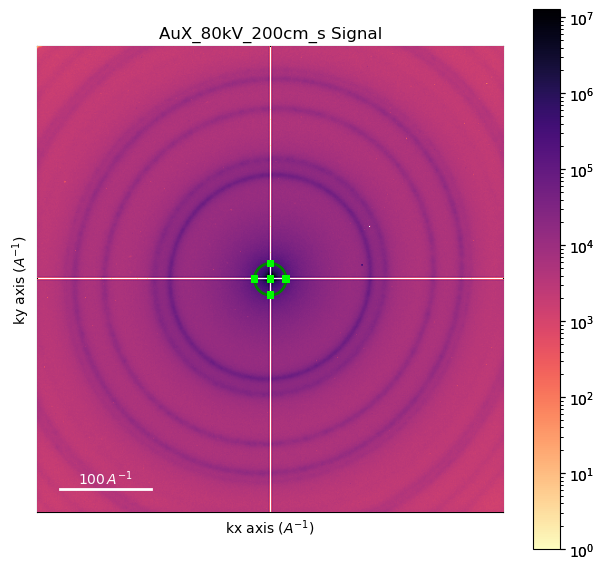

In [4]:
scale = 1
saed.set_diffraction_calibration(scale)
saed.plot(cmap='magma_r', norm='log')

roi = hs.roi.CircleROI(cx=0, cy=0, r=18, r_inner=0)
roi.add_widget(saed)

saed.save(folder+file+'_center.hdf5')

Plot SAED pattern with line trace:

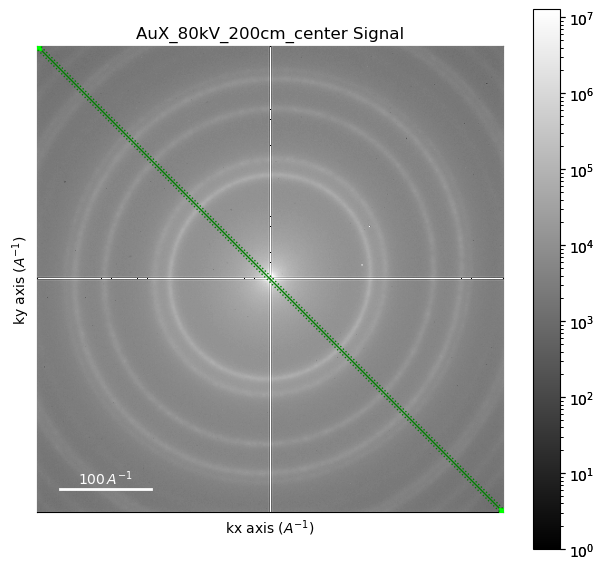

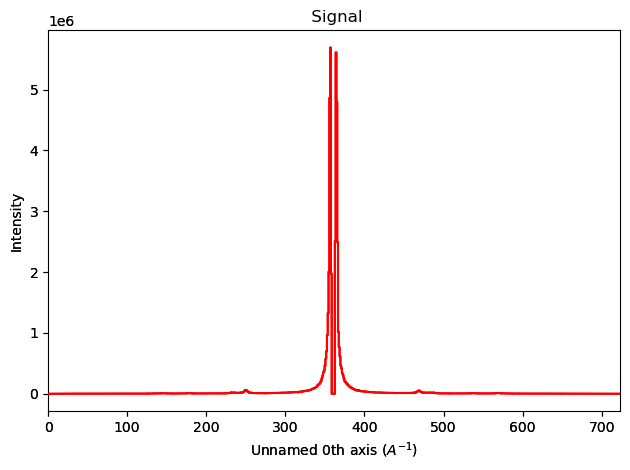

In [5]:

cal = CalibrationGenerator(diffraction_pattern=saed)

# Plot saed diffraction pattern
saed.plot(norm="log") 
# Adjust x1, y1, x2, y2 according to detector used
line = hs.roi.Line2DROI(x1=-256, y1=-256, x2=256, y2=256, linewidth=5) 
line.add_widget(saed)

# Obtain line trace (here set to go through center of beam)
trace = line(saed)
trace = trace.as_signal1D(0)
trace.plot()

Mask out direct beam:

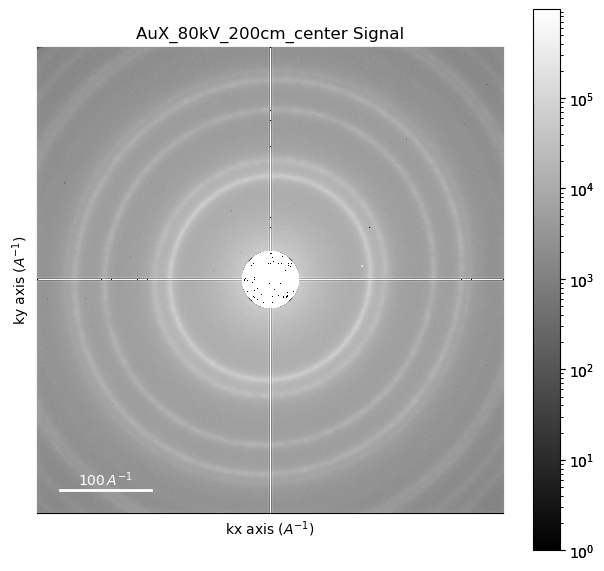

In [6]:
radius = 32 
ssum_m = saed.copy()
dbm = ssum_m.get_direct_beam_mask(radius=radius)
ssum_m.data = ssum_m.data * ~dbm.data
ssum_m.plot(norm="log")

Calculate distortion:

In [9]:
#   Mask radius, spread and asymmetry might have to be edited
#   Larger cameralength required higher mask_radius
spread =  3 
distortion = cal.get_elliptical_distortion(mask_radius=140, 
                                           scale=100, amplitude=1000,
                                           asymmetry=0.9, spread=spread)  
np.set_printoptions(precision=5, suppress=True)
print(cal.affine_matrix)
print(cal.ring_params)

c:\Users\Windows User\anaconda3\envs\masterENV\lib\site-packages\diffsims\utils\ring_pattern_utils.py:29: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((xp - xcp) ** 2 + asym * (yp - ycp) ** 2)


[[0.98772 0.01814 0.     ]
 [0.01814 0.9732  0.     ]
 [0.      0.      1.     ]]
[  259.56796 33567.41646     5.37941  4242.31408     0.92338    -0.59503]


Find scale and plot residuals:

[########################################] | 100% Completed | 136.47 ms
[########################################] | 100% Completed | 126.32 ms
[########################################] | 100% Completed | 115.20 ms
[########################################] | 100% Completed | 129.81 ms
scale=0.00386


c:\Users\Windows User\anaconda3\envs\masterENV\lib\site-packages\diffsims\utils\ring_pattern_utils.py:102: RuntimeWarning: divide by zero encountered in power
  v.append(direct_beam_amplitude * Ri ** -2)  # np.exp((-1*(Ri)*(Ri))/d0)


[########################################] | 100% Completed | 128.22 ms
[########################################] | 100% Completed | 229.93 ms
[########################################] | 100% Completed | 122.28 ms


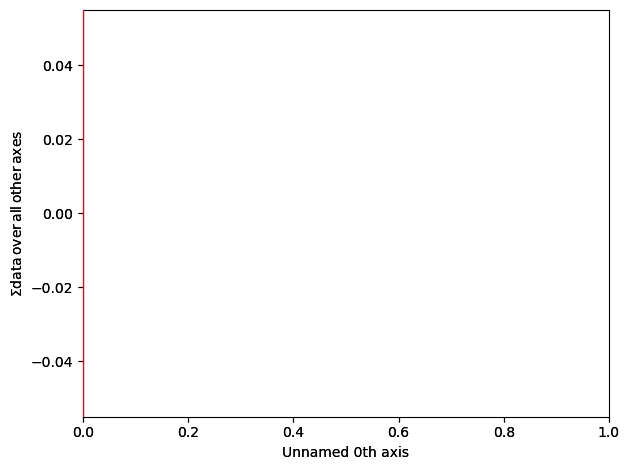

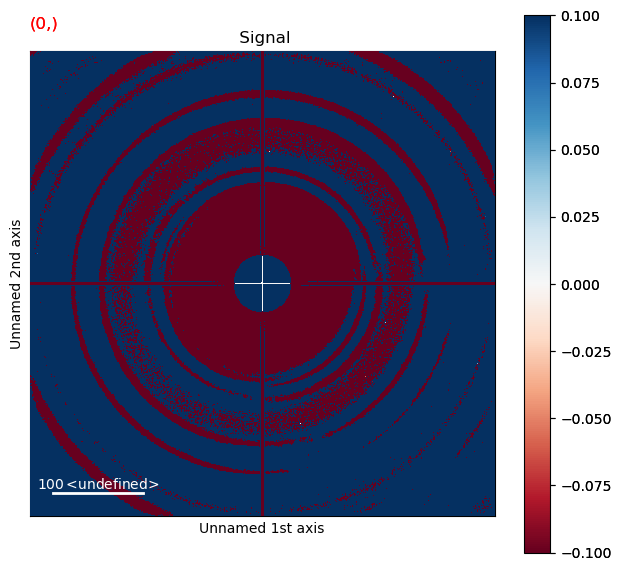

In [10]:
mask_length = radius # tror denne må være lik radiusen
linewidth = 5
scale = cal.get_diffraction_calibration(mask_length=mask_length, linewidth=linewidth) 
print('scale=' + '{:.5f}'.format(scale))

residuals = cal.get_distortion_residuals(mask_radius=radius, spread=spread)
residuals.plot(cmap='RdBu', vmax=0.04) 


Plot corrected diffraction pattern:

[########################################] | 100% Completed | 110.88 ms
[########################################] | 100% Completed | 119.38 ms


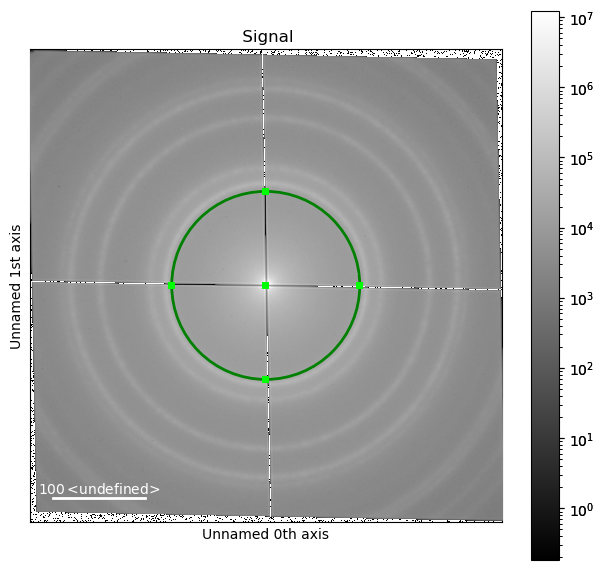

In [11]:
cal.plot_corrected_diffraction_pattern(norm="log")

In [12]:
# Save the distortion matrix
np.savetxt(folder + file + '_dist.txt', distortion)

## 2. Manual calibration of Au rings

[########################################] | 100% Completed | 120.66 ms
[########################################] | 100% Completed | 113.63 ms


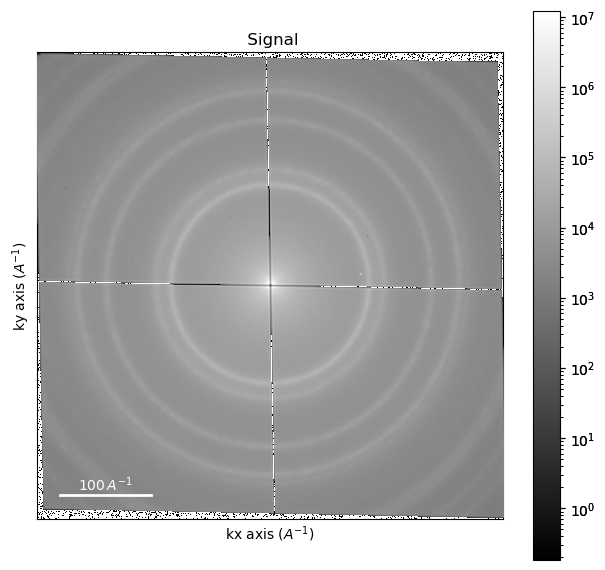

In [13]:
# Inverse d spacings for gold
ids = [0.424522257, 0.490196078, 0.693241942, 0.812898233, 0.849460916, 0.980872977]

size = ssum_m.data.shape[0]
dpegs = stack_method([saed, saed, saed, saed])
dpegs = pxm.signals.ElectronDiffraction2D(dpegs.data.reshape((2, 2, size, size)))

dpegs = dpegs.apply_affine_transformation(
    cal.affine_matrix, preserve_range=True, inplace=False)
dpegm = dpegs.inav[0, 0]

dpegm.set_diffraction_calibration(1)
dpegm.plot(norm='log')

Radius of Au rings to be plotted with the Au-pattern. Observe if the rings overlap, if not, adjust the radius.

30cm: 18.5, 21.5, 31.5, 37.5

40cm: 23.5, 27.5, 39.5, 46.5

50cm: 31.5, 34.5, 51.5, 58.5

60cm: 37.5, 43.5, 62.5, 73.5

80cm: 51.5, 58.5, 84.5, 99.5

100cm: 59.5, 69.5, 98.5, 115.5

120cm: 71.5, 84.5, 119.5, 139.5

150cm: 86.5, 100.5, 141.5, 165.5

200 cm: 106.5, 123.5, 175.5, 205.5

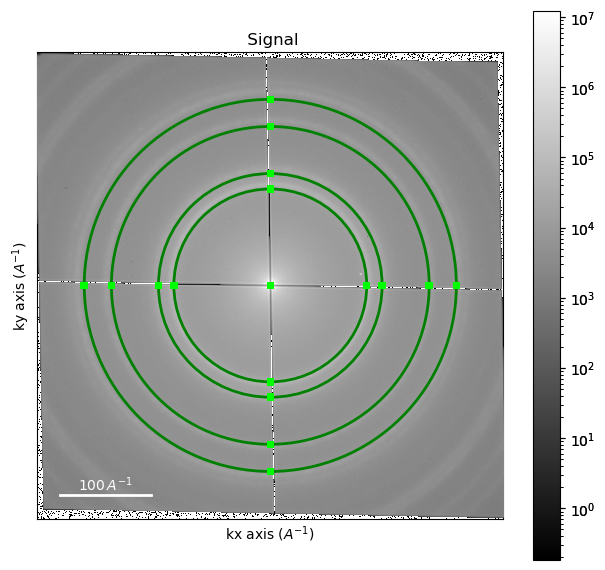

In [15]:
dpegm.set_diffraction_calibration(1)
dpegm.plot(norm='log')

roi111 = hs.roi.CircleROI(cx=0, cy=0, r=106.5)
roi111.add_widget(dpegm)
roi002 = hs.roi.CircleROI(cx=0, cy=0, r=123.5)
roi002.add_widget(dpegm)
roi022 = hs.roi.CircleROI(cx=0, cy=0, r=175.5)
roi022.add_widget(dpegm)
roi113 = hs.roi.CircleROI(cx=0, cy=0, r=205.5)
roi113.add_widget(dpegm)

Calculate mean of manually calculated scales:

In [16]:
scales = np.array([ids[0] / roi111.r, ids[1] / roi002.r, ids[2] / roi022.r, ids[3] / roi113.r])
print(scales, np.std(scales), np.mean(scales))
calibration = np.mean(scales)
print(calibration)

[0.00399 0.00397 0.00395 0.00396] 1.3892349026919517e-05 0.003965282297412139
0.003965282297412139


In [17]:

# Save calibration scale and figure
np.savetxt(folder + file + '_calibration_manual.txt', [calibration])

plt.savefig(folder+file + '_cal_rings.png')

<Figure size 640x480 with 0 Axes>

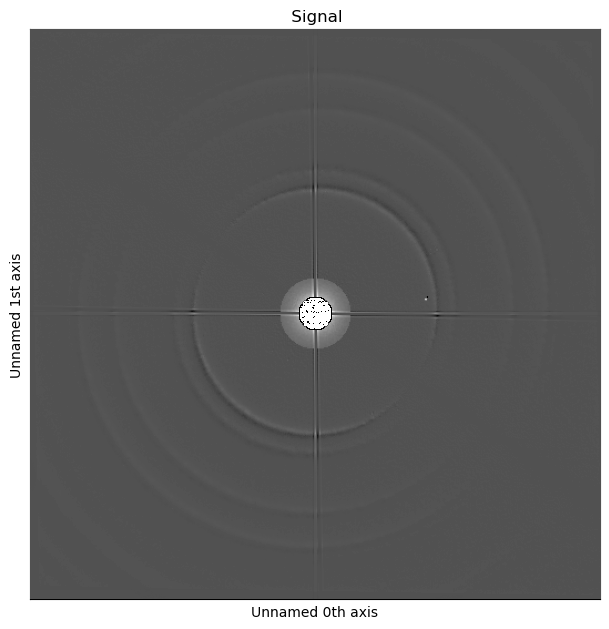

In [18]:
# Save png figure of shift
diff = dpegs.inav[0, 0].data - ssum_m.data
if np.any(diff < 0.0):
    diff = diff + abs(np.min(diff.data))

diff = pxm.signals.ElectronDiffraction2D(diff)
diff_m = diff.copy()
dbm_ = diff_m.get_direct_beam_mask(radius=15)
diff_m.data = diff_m.data * ~dbm_.data
diff_m.plot(norm='log', scalebar=False, colorbar=False, axes_ticks=False)
plt.savefig(folder + file + '_diff.png')
# Make tif
diff_img = diff_m.copy()
diff_img.data = diff_img.data / diff_img.data.max()
diff_img.data = ski.img_as_uint(diff_img.data)
diff_img.save(folder + file + '_diff.tif')
shift = diff_m.data[diff_m.data > 0].min()
# Make log tif
diff_log = diff_m.copy()
diff_log.data = log10(diff_m.data + shift) - log10(shift)
diff_log.data = diff_log.data / diff_log.data.max()
diff_log.data = ski.img_as_uint(diff_log.data)
diff_log.save(folder + file + '_diff_log.tif') 

## 3. Calculate eccentricity

The affine matrix found above can be used to calculate the eccentricity of the elliptical distortion.
For more info see: https://en.wikipedia.org/wiki/Eccentricity_(mathematics) 

In [1]:
def ecc(A, B, C, nu):
    
    # Equation for  eccentricity of ellipse
    # IN:   A, B and C are parameters in equation describing ellipse, Ax^2 + Bxy + Cy^2 = 0
    #       nu is determinant of 3x3 affine matrix from ellipticity correction.
    # OUT:  calculated eccentricity value

    return np.sqrt((2*np.sqrt((A-C)**2+B**2))/(nu*(A+C)+np.sqrt((A-C)**2+B**2)))

def readEccFromMatrix(file, folder):
    # IN: affine matrix from file with filename = file + folder 
    # OUT: eccentricity of affine amtrix

    filename = folder+file
    if file[-9:]!='_dist.txt':
        filename = folder +file + '_dist.txt'
    
    # Read the file: a 3x3 matrix
    with open(filename, "r") as file:
        lines = file.readlines()
    
    values1 = [float(val) for val in lines[0].strip('\n').split(' ')]
    A = float(values1[0])
    B = float(values1[1])*2
    values2 = [float(val) for val in lines[1].strip('\n').split(' ')]
    C = float(values2[1])
    nu = A*C-(B/2)**2

    print('Eccentricity: ', round(ecc(A, B, C, nu),3))
    return ecc(A, B, C, nu)

In [20]:
readEccFromMatrix(file, folder)

Eccentricity:  0.20156379298178292


0.202